In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp


In [2]:
train_data = pd.read_csv('mnist/mnist_train.csv')

df7 = train_data.loc[train_data['label']==7]
df1 = train_data.loc[train_data['label']==1]

## Example implementation of SVM in cvxpy 

In [7]:
#dataset 
np.random.seed(1)
n = 20
m = 1000
TEST = m
DENSITY = 0.2
beta_true = np.random.randn(n,1)
idxs = np.random.choice(range(n), int((1-DENSITY)*n), replace=False)
for idx in idxs:
    beta_true[idx] = 0
offset = 0
sigma = 45
X = np.random.normal(0, 5, size=(m,n))
Y = np.sign(X.dot(beta_true) + offset + np.random.normal(0,sigma,size=(m,1)))
X_test = np.random.normal(0, 5, size=(TEST,n))
Y_test = np.sign(X_test.dot(beta_true) + offset + np.random.normal(0,sigma,size=(TEST,1)))

In [8]:
#svm formulation
beta = cp.Variable((n,1))
v = cp.Variable()
loss = cp.sum(cp.pos(1 - cp.multiply(Y, X @ beta - v)))
reg = cp.norm(beta, 1)
lambd = cp.Parameter(nonneg=True)
prob = cp.Problem(cp.Minimize(loss/m + lambd*reg))

In [9]:
# Compute a trade-off curve and record train and test error.
TRIALS = 100
train_error = np.zeros(TRIALS)
test_error = np.zeros(TRIALS)
lambda_vals = np.logspace(-2, 0, TRIALS)
beta_vals = []
for i in range(TRIALS):
    lambd.value = lambda_vals[i]
    prob.solve()
    train_error[i] = (np.sign(X.dot(beta_true) + offset) != np.sign(X.dot(beta.value) - v.value)).sum()/m
    test_error[i] = (np.sign(X_test.dot(beta_true) + offset) != np.sign(X_test.dot(beta.value) - v.value)).sum()/TEST
    beta_vals.append(beta.value)

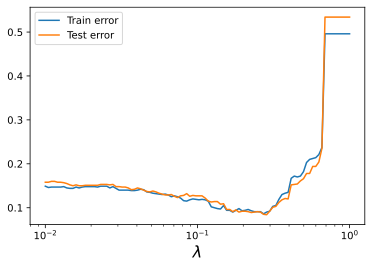

In [10]:
# Plot the train and test error over the trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.plot(lambda_vals, train_error, label="Train error")
plt.plot(lambda_vals, test_error, label="Test error")
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.show()

## Synthetic dataset

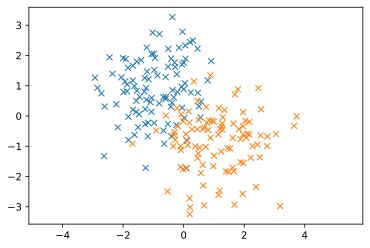

In [15]:
mean1 = [-1,1]
mean2 = [1,-1]
cov = [[1, 0], [0, 1]]
x1, y1 = np.random.multivariate_normal(mean1, cov, 100).T
x2, y2 = np.random.multivariate_normal(mean2, cov, 100).T

plt.plot(x1, y1, 'x')
plt.plot(x2, y2, 'x')
plt.axis('equal')
plt.show()

In [39]:
m = 3 #rows
l = 3 #columns
X ,Y= np.random.multivariate_normal(mean1, cov, 4).T
Z= np.random.multivariate_normal(mean1, cov, (m,1)).T
print(X,Y)
# print(Z)

[-0.27107071 -1.00078154 -0.18763688 -0.80753856] [ 3.12666893 -1.28550992  0.54687685  1.05453515]


## Defining project problem in cvxpy 

In [43]:
#svm formulation for synthetic 
m = 5 #rows
l = 4 #columns
num_samples =100
X , Y = np.random.multivariate_normal(mean1, cov, num_samples).T  # synthetic dataset

## M : dimension of 
W_ = cp.Variable((num_samples,1))
w_ = cp.Variable()
loss = cp.sum(cp.pos(1 - cp.multiply(Y, X @ W_ - w_)))
# reg = cp.norm(W, 1)
# lambd = cp.Parameter(nonneg=True)
prob = cp.Problem(cp.Minimize(loss/m))
prob.solve()

8.340041576648943

## reference
https://github.com/sdeepaknarayanan/Machine-Learning/blob/master/Assignment%207/HW7_SVM.ipynb  

https://www.baeldung.com/cs/svm-hard-margin-vs-soft-margin

# Preparing the data

In [17]:
dataset = pd.read_csv('mnist/mnist_train.csv')
train_data, train_label = dataset.drop(labels = ["label"],axis = 1).to_numpy(), dataset["label"]
trainlabel = dataset.loc[(dataset['label']== 1)  | (dataset['label']== 7) ]['label']
trainlabel.loc[trainlabel == 1] =1
trainlabel.loc[trainlabel == 7] =-1
traindata = dataset.loc[(dataset['label']== 1)  | (dataset['label']== 7) ]
traindata = traindata.drop(labels = ["label"],axis = 1).to_numpy()
trainlabel = trainlabel.to_numpy()

/home/anw/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/anw/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj._check_is_chained_assignment_possible()


In [11]:
def prepare_binary(class1:int,class2:int):
    #traindata
    trainlabel = dataset.loc[(dataset['label']== class1)  | (dataset['label']== class2) ]['label']
    trainlabel.loc[trainlabel == class1] = 1
    trainlabel.loc[trainlabel == class2] = -1
    trainlabel = trainlabel.to_numpy()

    # traindata
    traindata = dataset.loc[(dataset['label']== 1)  | (dataset['label']== 7) ]
    traindata = traindata.drop(labels = ["label"],axis = 1).to_numpy()
    return trainlabel,traindata

In [36]:
traindata.shape

(13007, 784)

# SVM formulation for mnist classes 1 and 7

In [32]:
#normal
m = traindata.shape[1]
W = cp.Variable((m,1))
w = cp.Variable()
objective_func = cp.Minimize(0.5*cp.norm(W,p=2)**2)
const = [trainlabel[i]*(traindata[i]@ W+w)>=1 for i in range(traindata.shape[0])]
prob = cp.Problem(objective_func,constraints=const)

# loss = cp.sum(cp.pos(1 - cp.multiply(train_data, input_row @ W - w)))
# prob = cp.Problem(cp.Minimize(loss/m))
prob.solve()

0.0009312605061763449

In [26]:
#hinge loss
m1 = traindata.shape[1]
W1 = cp.Variable((m,1))
w1 = cp.Variable()
objective_func1 = cp.Minimize(sum(cp.pos(1-cp.multiply(trainlabel,traindata*W1 + w1))))
# const = [trainlabel[i]*(traindata[i]@ W+w)>=1 for i in range(traindata.shape[0])]
prob1 = cp.Problem(objective_func1)
# loss = cp.sum(cp.pos(1 - cp.multiply(train_data, input_row @ W - w)))
# prob = cp.Problem(cp.Minimize(loss/m))
prob1.solve()

/home/anw/.local/lib/python3.8/site-packages/cvxpy/expressions/expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


ValueError: Cannot broadcast dimensions  (13007,) (13007, 1)

## Test Data

In [18]:
dataset_test = pd.read_csv('mnist/mnist_test.csv')
testlabel = dataset.loc[(dataset['label']== 1)  | (dataset['label']== 7) ]['label']
testlabel.loc[testlabel == 1] =1
testlabel.loc[testlabel == 7] =-1
testdata = dataset.loc[(dataset['label']== 1)  | (dataset['label']== 7) ]
testdata = testdata.drop(labels = ["label"],axis = 1).to_numpy()
testlabel = testlabel.to_numpy()

## Testing the classifier

In [23]:
testdata[8].dot(W.value) +  w.value

array([-9.55024793])

In [34]:
positive_class =[]
negative_class = []
for i in range(testdata.shape[0]):
    if testdata[i].dot(W.value) +  w.value>1:
        positive_class.append(testdata[i])
    if testdata[i].dot(W.value) +  w.value<-1:
        negative_class.append(testdata[i])
        

6742

In [12]:
train_error = (np.sign(X.dot(beta_true)) != np.sign(traindata[i].dot(W.value) +  w.value))
test_error[i] = (np.sign(X_test.dot(beta_true) + offset) != np.sign(X_test.dot(beta.value) - v.value)).sum()/TEST

Variable(())

In [58]:
train_label.shape

(60000,)